# Urban Demography - GUDD Figures

- Author: Andrew Zimmer 
- Date Created: 2024-11-14 
- Last Edited:  2024-11-14 
- Version: 1.0

Description: 
- This script plots the main figures for the manuscript

Input Files:
- './01_data/04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv'
- './01_data/04_final_demographic_data/01_static_boundaries/gudd_change_2000_2020_static_boundaries.csv'

Output Files:
- './03_documents/01_main_figures/fig1_udr_map.pdf'
- './03_documents/01_main_figures/fig2_usr_map.pdf'
- './03_documents/01_main_figures/fig3_citysize_ydr.pdf'
- './03_documents/01_main_figures/fig4_migration.pdf'

In [19]:
# imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, ConnectionPatch
import numpy as np
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager, colors

# data folder
data_folder = '../01_data/'
figure_folder = '../03_documents/01_main_figures/'


In [20]:
# load input files
annual_metrics = pd.read_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv')
change_data = pd.read_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_change_2000_2020_static_boundaries.csv')

# Figure 1 - Global Dependency Ratio (& Change 2000-2020)

In [21]:
# only keep cities that appeared for the entire 2000-2020 time period
# limit annual metrics to only include 2020, for plotting
annual_metrics_2020 = annual_metrics[
    (annual_metrics["YearOfBirth"] <= 2000) &
    (annual_metrics["YearOfDeath"] >= 2020) &
    (annual_metrics["year"] == 2020)
].copy()

change_data = change_data[
    (change_data["YearOfBirth"] <= 2000) &
    (change_data["YearOfDeath"] >= 2020)
].copy()

In [22]:
world = gpd.read_file(Path(data_folder) / '02_auxiliary_data/03_mapping/ne_50m_admin_0_countries.shp')

In [23]:
# set colors
# dependency ratio colors
colors_dr = [
    "#053061", "#2166AC", "#4393C3", "#92C5DE",
    "#D1E5F0", "#F4A582", "#D6604D", "#B2182B", "#67001F"
]

# change colors
colors_delta = [
    "#40004B", "#762A83", "#9970AB", "#C2A5CF", "#E7D4E8",
    "#D9F0D3", "#A6DBA0", "#5AAE61", "#1B7837", "#00441B"
]

cmap_dr = mcolors.LinearSegmentedColormap.from_list("dr", colors_dr)
cmap_delta = mcolors.LinearSegmentedColormap.from_list("delta", colors_delta)

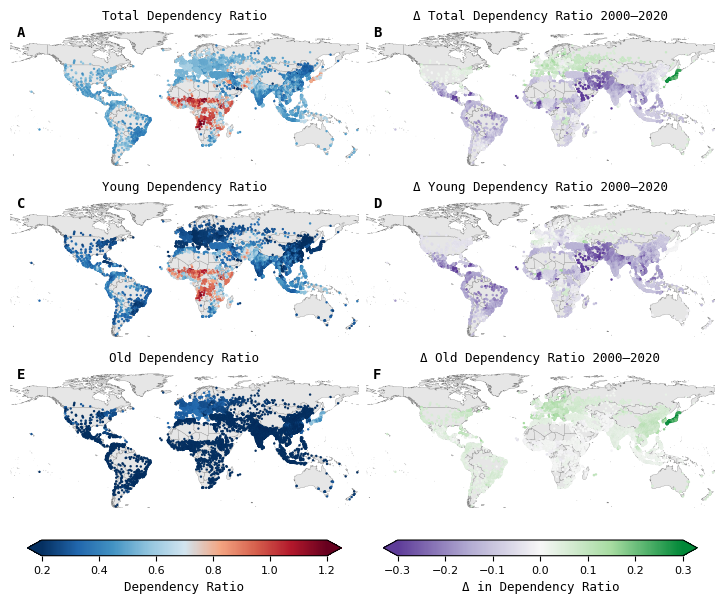

In [28]:
# font setup
font_prop = font_manager.FontProperties(family="DejaVu Sans Mono")
subplot_letters = ["A", "B", "C", "D", "E", "F"]

# Function to slightly darken a color for outside line
def darken_color(c, amount=0.01):
    """
    Darken a matplotlib color by multiplying its RGB components by `amount`.
    """
    c_rgb = colors.to_rgb(c)
    return tuple(np.array(c_rgb) * amount)

# Map plotting function
def plot_map(ax, data, column, cmap, vmin, vmax, title, letter=None):
    # Basemap
    world.plot(
        ax=ax,
        color="#E6E6E6",
        edgecolor="0.5",
        linewidth=0.2,
        zorder=1
    )

    # Normalize colors to colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = cmap(norm(data[column]))

    # Slightly darker edge color for each point
    edge_colors = np.array([darken_color(c[:3], 0.6) + (c[3],) for c in rgba_colors])

    # Scatter
    sc = ax.scatter(
        data["longitude"],
        data["latitude"],
        c=rgba_colors,
        s=3,
        edgecolor=edge_colors,
        linewidth=0.0005,
        zorder=2
    )

    # Axis styling
    ax.set_xlim(-180, 180)
    ax.set_ylim(-55, 90)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.3, alpha=1)

    # Title
    ax.set_title(
        title,
        fontproperties=font_prop,
        fontsize=9,
        pad=4
    )

    # Subplot letter
    if letter:
        ax.text(
            0.02, 1, letter,
            transform=ax.transAxes,
            fontproperties=font_prop,
            fontsize=10,
            fontweight="bold",
            va="top",
            ha="left",
            zorder=3
        )

    return sc, norm

# Figure setup
fig, axes = plt.subplots(
    3, 2,
    figsize=(7.087, 6),  
    constrained_layout=True
)

# Spacing pads
fig.set_constrained_layout_pads(
    w_pad=0.02,
    h_pad=0.02,
    hspace=0.02,
    wspace=0.02
)

# Plot each map
sc1, norm1 = plot_map(axes[0,0], annual_metrics_2020, "total_dr", cmap_dr, 0.2, 1.2,
                      "Total Dependency Ratio", letter=subplot_letters[0])

sc2, norm2 = plot_map(axes[0,1], change_data, "total_dr_Delta", cmap_delta, -0.3, 0.3,
                      "Δ Total Dependency Ratio 2000–2020", letter=subplot_letters[1])

sc3, norm3 = plot_map(axes[1,0], annual_metrics_2020, "young_dr", cmap_dr, 0.2, 1.2,
                      "Young Dependency Ratio", letter=subplot_letters[2])

sc4, norm4 = plot_map(axes[1,1], change_data, "young_dr_Delta", cmap_delta, -0.3, 0.3,
                      "Δ Young Dependency Ratio 2000–2020", letter=subplot_letters[3])

sc5, norm5 = plot_map(axes[2,0], annual_metrics_2020, "old_dr", cmap_dr, 0.2, 1.2,
                      "Old Dependency Ratio", letter=subplot_letters[4])

sc6, norm6 = plot_map(axes[2,1], change_data, "old_dr_Delta", cmap_delta, -0.3, 0.3,
                      "Δ Old Dependency Ratio 2000–2020", letter=subplot_letters[5])

# Colorbars
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm1, cmap=cmap_dr),
    ax=axes[:,0],
    orientation="horizontal",
    fraction=0.04,
    pad=0.06,
    shrink=0.9,
    extend='both'
)

cbar2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm2, cmap=cmap_delta),
    ax=axes[:,1],
    orientation="horizontal",
    fraction=0.04,
    pad=0.06,
    shrink=0.9,
    extend='both'
)

# Colorbar labels
for cbar, label in zip([cbar1, cbar2], ["Dependency Ratio", "Δ in Dependency Ratio"]):
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xlabel(label, fontsize=9, fontproperties=font_prop)

# Save as PDF
output_file = Path(figure_folder) / 'fig1_udr_map.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()

# Figure 2 - Working-Age Sex Ratio (Global & Arabia Inset)

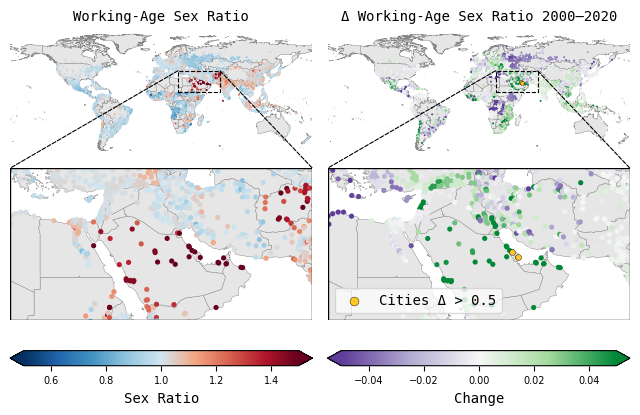

In [30]:
#colormaps
colors_sr = [
    "#053061", "#2166AC", "#4393C3", "#92C5DE",
    "#D1E5F0", "#F4A582", "#D6604D", "#B2182B", "#67001F"
]

colors_delta = [
    "#5e3c99", "#b2abd2", "#f7f7f7", "#a6dba0", "#008837"
]

cmap_sr = mcolors.LinearSegmentedColormap.from_list("sr", colors_sr)
cmap_delta = mcolors.LinearSegmentedColormap.from_list("delta", colors_delta)

# inset region over arabian peninsula
INSET_XMIN = 20
INSET_XMAX = 70
INSET_YMIN = 15
INSET_YMAX = 40

highlight = change_data[change_data["working_sr_Delta"] > 0.5]

# draw region box on the main map
def draw_region_box(ax):
    rect = Rectangle(
        (INSET_XMIN, INSET_YMIN),
        INSET_XMAX - INSET_XMIN,
        INSET_YMAX - INSET_YMIN,
        fill=False,
        linestyle="--",
        linewidth=0.8,
        edgecolor="black",
        zorder=4
    )
    ax.add_patch(rect)

# draw box around inset panel
def draw_inset_panel_box(ax):
    rect = Rectangle(
        (0,0), 1, 1,
        transform=ax.transAxes,
        fill=False,
        linewidth=1,
        edgecolor="black",
        zorder=5
    )
    ax.add_patch(rect)

# connect top corners for inset map
def connect_axes(fig, ax_main, ax_inset):
    con1 = ConnectionPatch(
        xyA=(INSET_XMIN, INSET_YMAX),
        coordsA=ax_main.transData,
        xyB=(0,1),
        coordsB=ax_inset.transAxes,
        linestyle="--",
        linewidth=0.8,
        color="black"
    )
    con2 = ConnectionPatch(
        xyA=(INSET_XMAX, INSET_YMAX),
        coordsA=ax_main.transData,
        xyB=(1,1),
        coordsB=ax_inset.transAxes,
        linestyle="--",
        linewidth=0.8,
        color="black"
    )
    fig.add_artist(con1)
    fig.add_artist(con2)

# main plotting function
def plot_map(
    ax,
    data,
    column,
    cmap,
    title,
    vmin,
    vmax,
    inset=False,
    region_box=False,
    inset_box=False,
    highlight_points=None
):
    world.plot(
        ax=ax,
        color="#E6E6E6",
        edgecolor="0.5",
        linewidth=0.3,
        zorder=1
    )

    # symbol size in inset map
    base_size = 14 if inset else 2

    # plot all points first
    sc = ax.scatter(
        data["longitude"],
        data["latitude"],
        c=data[column],
        cmap=cmap,
        s=base_size,
        vmin=vmin,
        vmax=vmax,
        linewidth=0,
        zorder=2
    )

    # overlay highlight points in bright yellow
    highlight_handle = None
    if highlight_points is not None and len(highlight_points):
        hl_size = 18 if inset else 8
        highlight_handle = ax.scatter(
            highlight_points["longitude"],
            highlight_points["latitude"],
            s=hl_size,
            facecolor="#ffc425",
            edgecolor="black",
            linewidth=0.3,
            zorder=3,
            label=f"Cities Δ > 0.5"
        )

    if region_box:
        draw_region_box(ax)
    if inset_box:
        draw_inset_panel_box(ax)

    if inset:
        ax.set_xlim(INSET_XMIN, INSET_XMAX)
        ax.set_ylim(INSET_YMIN, INSET_YMAX)
    else:
        ax.set_xlim(-180,180)
        ax.set_ylim(-55,90)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(
        title,
        fontproperties=font_prop,
        fontsize=10
    )

    return sc, highlight_handle

# figure layout
fig, axes = plt.subplots(
    2,2,
    figsize=(8,6),
    gridspec_kw={'hspace':0.05, 'wspace':0.05}
)

# main maps
sc1,_ = plot_map(
    axes[0,0],
    annual_metrics_2020,
    "working_sr",
    cmap_sr,
    "Working-Age Sex Ratio",
    0.5,1.5,
    region_box=True
)

vmin_delta, vmax_delta = -0.05, 0.05

sc2, hl = plot_map(
    axes[0,1],
    change_data,
    "working_sr_Delta",
    cmap_delta,
    "Δ Working-Age Sex Ratio 2000–2020",
    vmin_delta,
    vmax_delta,
    region_box=True,
    highlight_points=highlight
)

# inset maps
sc3,_ = plot_map(
    axes[1,0],
    annual_metrics_2020,
    "working_sr",
    cmap_sr,
    "",
    0.5,1.5,
    inset=True,
    inset_box=True
)

sc4,_ = plot_map(
    axes[1,1],
    change_data,
    "working_sr_Delta",
    cmap_delta,
    "",
    vmin_delta,
    vmax_delta,
    inset=True,
    inset_box=True,
    highlight_points=highlight
)

# connectors
connect_axes(fig, axes[0,0], axes[1,0])
connect_axes(fig, axes[0,1], axes[1,1])

# colorbars
cbar1 = fig.colorbar(
    sc1,
    ax=[axes[0,0], axes[1,0]],
    orientation="horizontal",
    fraction=0.05,
    pad=0.08,
    extend='both'
)
cbar1.set_label("Sex Ratio", fontproperties=font_prop)
cbar1.ax.tick_params(labelsize=7)   # ← smaller numbers


cbar2 = fig.colorbar(
    sc2,
    ax=[axes[0,1], axes[1,1]],
    orientation="horizontal",
    fraction=0.05,
    pad=0.1,
    extend='both'
)
cbar2.set_label("Change", fontproperties=font_prop)
cbar2.ax.tick_params(labelsize=7)   # ← smaller numbers

# legend for highlight (yellow dot)
if hl is not None:
    axes[1,1].legend(
        frameon=True,
        fontsize=7,
        prop=font_prop,
        loc='lower left',
        markerscale=1.5,
        facecolor='white',
        framealpha=0.7
    )

# final spacing
plt.subplots_adjust(
    wspace=0.02,
    hspace=0.01,   
    bottom=0.2,
    top=0.75      
)

output_file = Path(figure_folder) / 'fig2_usr_map.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()


# Figure 3 - Boxplot of YDR across city sizes

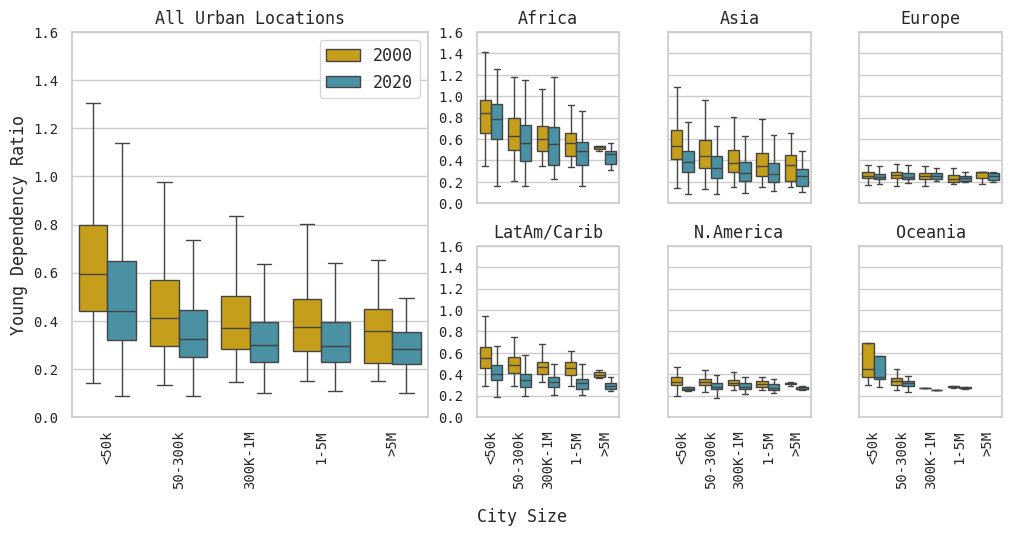

In [ ]:
# prepare data
boxplot_data = annual_metrics[['ID_UC_G0', 'year', 'young_dr', 'total_pop', 'Continent']].copy()
boxplot_data = boxplot_data[(boxplot_data['year'].isin([2000, 2020])) & (boxplot_data['Continent'] != "#N/A")]

# map continents to continent groups
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
boxplot_data['ContinentGroup'] = boxplot_data['Continent'].map(continent_map)
boxplot_data = boxplot_data.dropna(subset=['ContinentGroup'])

# categorize city size based on population thresholds
def city_size_label(pop):
    if pop <= 50000:
        return "<50k"
    elif 50000 < pop <= 300000:
        return "50-300k"
    elif 300000 < pop <= 1000000:
        return "300K-1M"
    elif 1000000 < pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"

city_size_order = ["<50k", "50-300k", "300K-1M", "1-5M", ">5M"]
boxplot_data['CitySize'] = pd.Categorical(
    boxplot_data['total_pop'].apply(city_size_label),
    categories=city_size_order, ordered=True
)
boxplot_data['year'] = boxplot_data['year'].astype(str)

# figure setup
sns.set(style="whitegrid")
mono_font = font_manager.FontProperties(family="DejaVu Sans Mono")
palette = {"2000":"#E1AF00", "2020":"#3B9AB2"}
continent_groups = ["Africa", "Asia", "Europe", "LatAm/Carib", "N.America", "Oceania"]

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1],
              wspace=0.25, hspace=0.25)

title_fontsize = 12
tick_fontsize_x = 10
tick_fontsize_y = 10

# left panel - all urban locations
ax_all = fig.add_subplot(gs[:, 0])
sns.boxplot(
    data=boxplot_data,
    x='CitySize',
    y='young_dr',
    hue='year',
    palette=palette,
    dodge=True,
    linewidth=1,
    fliersize=0,
    showfliers=False,
    ax=ax_all
)
ax_all.set_ylabel("Young Dependency Ratio", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_title("All Urban Locations", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_ylim(0, 1.6)
ax_all.set_yticks([i*0.2 for i in range(9)])
ax_all.tick_params(axis='x', rotation=90, labelsize=tick_fontsize_x)
ax_all.set_xlabel(None)  # remove the x axis label


# manually set tick fonts
for tick in ax_all.get_yticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_y)
for tick in ax_all.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_x)

# legend only on main plot
handles, labels = ax_all.get_legend_handles_labels()
ax_all.legend(handles, labels, title="", prop=mono_font, loc='upper right')

# right panel - split by continent
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col+1])
    cont_data = boxplot_data[boxplot_data['ContinentGroup'] == cont]
    
    sns.boxplot(
        data=cont_data,
        x='CitySize',
        y='young_dr',
        hue='year',
        palette=palette,
        dodge=True,
        linewidth=1,
        fliersize=0,
        showfliers=False,
        ax=ax
    )
    
    ax.set_title(cont, fontproperties=mono_font, fontsize=title_fontsize)
    ax.set_xlabel(None)  # remove the x-axis label
    
    # show x-axis tick labels only on bottom row of subplots
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=tick_fontsize_x, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # remove y-axis labels for non-left columns
    if col != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("", fontproperties=mono_font, fontsize=title_fontsize)
    
    ax.set_ylim(0, 1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    
    # manually adjust y tick font size
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(tick_fontsize_y)
    
    # remove legend from subplots
    ax.get_legend().remove()

# single centered x label under the entire figure
fig.text(0.5, -0.1, "City Size", fontproperties=mono_font, fontsize=title_fontsize, ha='center')

output_file = Path(figure_folder) / 'fig3_citysize_ydr.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()


# Figure 4 - Net Migration v Natural Change

/tmp/ipykernel_40580/634998202.py:286: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



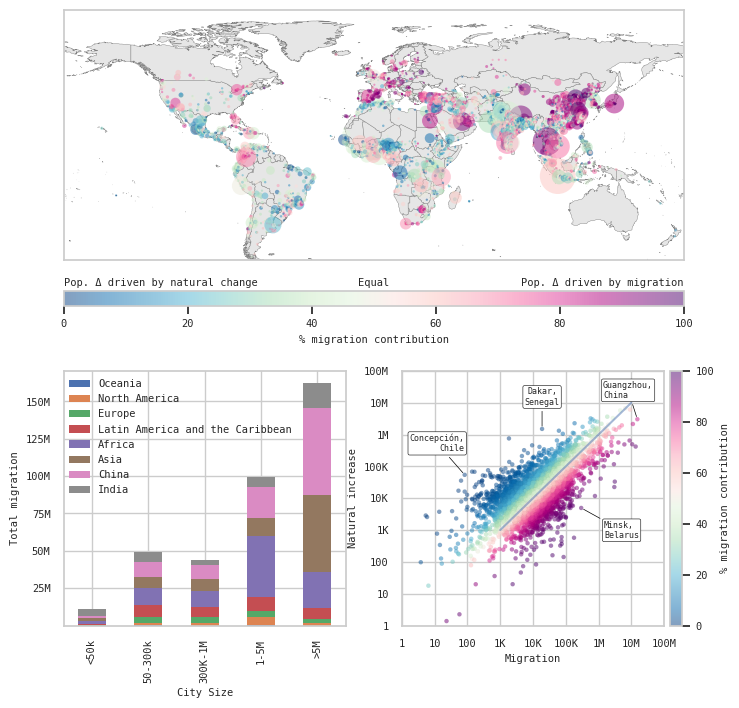

In [ ]:
# font setup
font_prop = FontProperties(family="DejaVu Sans Mono", size=7.5)  # all non-city elements
small_font = font_prop  # for ticks or smaller text if needed
label_font = FontProperties(family="DejaVu Sans Mono", size=6)  # city labels remain smaller

mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['font.size'] = font_prop.get_size()

# data preparation
migration_map_data = change_data.copy()

migration_map_data = migration_map_data[
    (migration_map_data["total_migration"] > 0) &
    (migration_map_data["natural_change"] > 0)
].copy()

# continent mapping - rest of asia here for figure
continent_map = {

'Oceania': 'Oceania',
'Australia and New Zealand': 'Oceania',

'Latin America and the Caribbean': 'Latin America and the Caribbean',

'Sub-Saharan Africa': 'Africa',
'Northern Africa and Western Asia': 'Africa',

'Europe': 'Europe',

'Central and Southern Asia': 'Rest of Asia',
'Eastern and South-Eastern Asia': 'Rest of Asia',

'Northern America': 'North America'

}

migration_map_data["Continent"] = migration_map_data["Continent"].map(continent_map)

migration_map_data.loc[
migration_map_data["Country"]=="China","Continent"]="China"

migration_map_data.loc[
migration_map_data["Country"]=="India","Continent"]="India"

# city size delineation
def city_size_label(pop):

    if pop <= 50000:
        return "<50k"
    elif pop <= 300000:
        return "50-300k"
    elif pop <= 1000000:
        return "300K-1M"
    elif pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"


city_size_order = ["<50k","50-300k","300K-1M","1-5M",">5M"]

migration_map_data["CitySize"] = pd.Categorical(
migration_map_data["total_pop_2020"].apply(city_size_label),
categories=city_size_order,
ordered=True
)

# stacked bar plot
stacked_data = migration_map_data.groupby(
["CitySize","Continent"],as_index=False
)["total_migration"].sum()

continent_order = [
"Oceania",
"North America",
"Europe",
"Latin America and the Caribbean",
"Africa",
"Rest of Asia",
"China",
"India"
]

stacked_data = stacked_data[
stacked_data["Continent"].isin(continent_order)
]

stacked_pivot = stacked_data.pivot_table(
index="CitySize",
columns="Continent",
values="total_migration",
fill_value=0
).reindex(index=city_size_order,columns=continent_order)

# color palettes
nat_colors = ['#084081','#0868ac','#2b8cbe','#4eb3d3',
'#7bccc4','#a8ddb5','#ccebc5','#e0f3db']

mig_colors = ['#fde0dd','#fcc5c0','#fa9fb5','#f768a1',
'#dd3497','#ae017e','#7a0177','#49006a']

full_colors = nat_colors + mig_colors

cmap = mcolors.LinearSegmentedColormap.from_list(
"migration",
full_colors
)

norm = mcolors.Normalize(0,100)

# size scale, setting min and max for point size
sizes = np.interp(
migration_map_data["total_pop_Delta"],
(
migration_map_data["total_pop_Delta"].min(),
migration_map_data["total_pop_Delta"].max()
),
(2,800)
)

# figure layout
fig = plt.figure(figsize=(8,8))

gs = GridSpec(
2,2,
height_ratios=[1.2,1],
hspace=0.2,
wspace=0.20
)

# PANEL A
ax_map = fig.add_subplot(gs[0,:])

world.plot(
ax=ax_map,
color="#E6E6E6",
edgecolor="0.5",
linewidth=0.3
)

sc_map = ax_map.scatter(
migration_map_data.longitude,
migration_map_data.latitude,
c=migration_map_data.perc_from_migration,
cmap=cmap,
norm=norm,
s=sizes,
edgecolor="black",
linewidth=0,
alpha=0.5
)

ax_map.set_xlim(-180,180)
ax_map.set_ylim(-55,90)

ax_map.set_xticks([])
ax_map.set_yticks([])

# wider colorbar
cbar = fig.colorbar(
sc_map,
ax=ax_map,
orientation="horizontal",

fraction=0.08,   # wider
pad=0.10,
aspect=40        # wider shape
)

cbar.set_label(
    "% migration contribution",
    fontproperties=font_prop
)

# smaller tick font
for tick in cbar.ax.get_xticklabels():
    tick.set_fontproperties(font_prop)

# top labels above colorbar to indicate direction of mig/nat change
cbar.ax.text(
0.0, 1.2,
"Pop. Δ driven by natural change",
ha='left',
va='bottom',
transform=cbar.ax.transAxes,
fontproperties=font_prop
)

cbar.ax.text(
0.5, 1.2,
"Equal",
ha='center',
va='bottom',
transform=cbar.ax.transAxes,
fontproperties=font_prop
)

cbar.ax.text(
1.0, 1.2,
"Pop. Δ driven by migration",
ha='right',
va='bottom',
transform=cbar.ax.transAxes,
fontproperties=font_prop
)

# PANEL B
ax_bar = fig.add_subplot(gs[1,0])

stacked_pivot.plot(
kind="bar",
stacked=True,
ax=ax_bar,
linewidth=0
)

ax_bar.set_ylabel(
"Total migration",
fontproperties=font_prop
)

yticks = ax_bar.get_yticks()

ax_bar.set_yticklabels(
[f"{int(y/1e6)}M" if y>0 else "0" for y in yticks],
fontproperties=font_prop
)

for tick in ax_bar.get_xticklabels():
    tick.set_fontproperties(font_prop)

handles,labels = ax_bar.get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    prop=font_prop,
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(0.12,0.43)
)
ax_bar.set_xlabel("City Size",fontproperties=font_prop)

ax_bar.get_legend().remove()

# PANEL C
ax_scatter = fig.add_subplot(gs[1,1])

sc = ax_scatter.scatter(
migration_map_data["total_migration"],
migration_map_data["natural_change"],
c=migration_map_data["perc_from_migration"],
cmap=cmap,
norm=norm,
s=10,
edgecolor="black",
linewidth=0.01,
alpha=0.5
)

ax_scatter.set_xscale("log")
ax_scatter.set_yscale("log")

lims = [1e3,1e7]

ax_scatter.set_xlim(lims)
ax_scatter.set_ylim(lims)

ax_scatter.plot(
lims,
lims,
alpha=0.5
)

ticks = [1,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]

labels = ["1","10","100","1K","10K","100K","1M","10M","100M"]

ax_scatter.set_xticks(ticks)
ax_scatter.set_xticklabels(labels,fontproperties=font_prop)

ax_scatter.set_yticks(ticks)
ax_scatter.set_yticklabels(labels,fontproperties=font_prop)

ax_scatter.set_xlabel("Migration",fontproperties=font_prop)
ax_scatter.set_ylabel("Natural increase",fontproperties=font_prop)


# scatter colorbar
cbar2 = fig.colorbar(
sc,
ax=ax_scatter,
fraction=0.05,
pad=0.02
)
for tick in cbar2.ax.get_yticklabels():  # for vertical colorbar
    tick.set_fontproperties(font_prop)

for tick in cbar2.ax.get_xticklabels():  # in case orientation='horizontal'
    tick.set_fontproperties(font_prop)


cbar2.set_label(
"% migration contribution",
fontproperties=font_prop
)

# Label selected cities
label_font = FontProperties(family="DejaVu Sans Mono", size=6)

label_specs = {

    ("Guangzhou", "China"): {
        "xmult": 0.09,
        "ymult": 4.0,
        "ha": "left",
        "va": "bottom"
    },

    ("Dakar", "Senegal"): {
        "xmult": 1.0,
        "ymult": 5.0,
        "ha": "center",
        "va": "bottom"
    },

    ("Minsk", "Belarus"): {
        "xmult": 5.0,
        "ymult": 0.4,
        "ha": "left",
        "va": "top"
    },

    ("Concepción", "Chile"): {
        "xmult": 1,
        "ymult": 20.0,
        "ha": "right",
        "va": "top"
    },


}

for (name, country), spec in label_specs.items():

    row = migration_map_data[
        (migration_map_data["Name"] == name) &
        (migration_map_data["Country"] == country)
    ]

    if row.empty:
        continue

    x = row["total_migration"].values[0]
    y = row["natural_change"].values[0]

    x_text = x * spec["xmult"]
    y_text = y * spec["ymult"]

    label_text = f"{name},\n{country}"

    ax_scatter.annotate(
        label_text,
        xy=(x, y),
        xytext=(x_text, y_text),
        textcoords="data",
        arrowprops=dict(
            arrowstyle="-",
            linewidth=0.5,
            color="black"
        ),
        bbox=dict(
            boxstyle="round,pad=0.2",
            fc="white",
            ec="black",
            linewidth=0.4
        ),
        fontproperties=label_font,
        ha=spec["ha"],
        va=spec["va"]
    )

# save and show plot
output_file = Path(figure_folder) / 'fig4_migration.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()